In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array
import Constants as C
from WeightTool import WeightTool
from matplotlib.colors import LogNorm
from Loader import Loader

from PlotTool import PlotTool
from Cuts import qratio, getQAB, qlayerCut

savedir = '../plots/eheredefined/'

In [5]:
# Define some baseline selection and then initialize the loader
sel = C.basesel + '&&(25<ImpLF_rchi2 && ImpLF_rchi2<80)'
loader = Loader(sel)

# Load Corsika and NuMu
#dt_numu = loader.getNuMu('log10(PrimaryNeutrinoEnergy) >= 6')
dt_numu = loader.getNuMu()
dt_cor  = loader.getCorsika() 



In [3]:
# Break data set into inner and outter portions
d_numu_in  = qlayerCut(dt_numu, True, 0.8)
d_numu_out = qlayerCut(dt_numu, False, 0.8)
d_cor_in   = qlayerCut(dt_cor, True, 0.8)
d_cor_out  = qlayerCut(dt_cor, False, 0.8)

sf = 364 / 34.7
print "NuGen Inner:   ", sum(d_numu_in['wE2']) * sf, "Outer: ", sum(d_numu_out['wE2']) * sf
print "Corsika Inner: ", sum(d_cor_in['w'])* sf, "Outer: ", sum(d_cor_out['w']) * sf

NuGen Inner:    22.9130618855 Outer:  21.0625166667
Corsika Inner:  17635625.8103 Outer:  9043616.49454


In [4]:
# We are concerned with PeV events so pull those off
d_numupev_in = d_numu_in[ np.log10(d_numu_in['PrimaryNeutrinoEnergy']) >= 6]
d_numupev_out = d_numu_out[ np.log10(d_numu_out['PrimaryNeutrinoEnergy']) >= 6]

# To make things easier for plotting make dictionary
info = {'data' : [d_cor_in, d_numu_in, d_numupev_in,
                  d_cor_out, d_numu_out, d_numupev_out],
        'col' : ['r','g','b','m','y','c'],
        'lbl' : [r'Atmos. $\mu$ (in)',
                 r'Atmos. $\nu_{\mu}$ (in)', 
                 r'Astro. $\nu_{\mu}$ (in, E>PeV)', 
                 r'Atmos. $\mu$ (out)',
                 r'Atmos. $\nu_{\mu}$ (out)', 
                 r'Astro. $\nu_{\mu}$ (out, E>PeV)'],
        'ls'  : ['solid','solid','solid','dashed','dashed','dashed'],
        'w'   : ['w','w','wE2','w','w','wE2']
        }

In [10]:
# Simple method to plot basic vars
def plot(info, var, xl, nbins, xmin, xmax, logy, sname, ysf=1e-10):
    fig, ax = plt.subplots(ncols=1,figsize=(7,6))
    ymax = -9999
    for i in range(len(info['data'])):
        dt  = info['data'][i]
        col = info['col'][i]
        lbl = info['lbl'][i]
        ls  = info['ls'][i]
        w   = info['w'][i]
        bc, bins, p = plt.hist(dt[var].as_matrix(),
                               weights=dt[w].as_matrix(),
                               bins=nbins, range=(xmin,xmax),
                               color=col, label=lbl, lw=1.5,
                               histtype='step', ls = ls
                               )
        
        plt.xlabel(xl)
        plt.ylabel(C.lt_label)
        plt.tight_layout()
    
        if bc.max() > ymax:
            ymax = bc.max()
    
    if logy:
        ax.set_yscale('log')
        plt.ylim([ymax*ysf,5*ymax])
    plt.legend(loc='best',fontsize='medium')
    plt.grid()
    plt.savefig(savedir+sname+'.png')

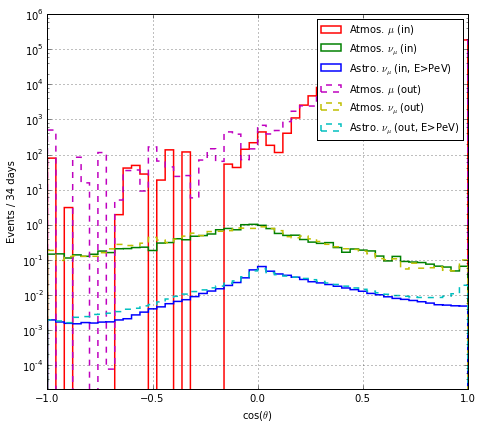

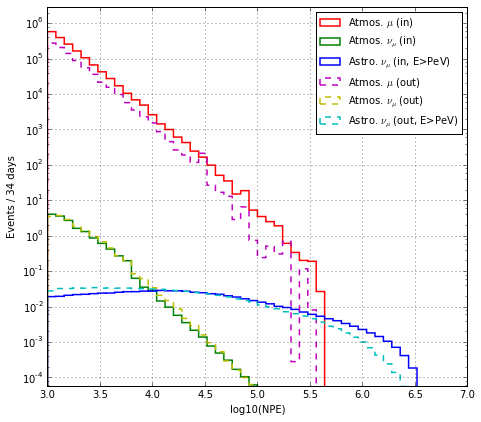

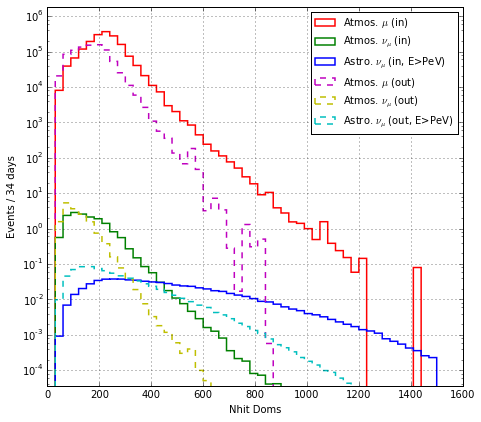

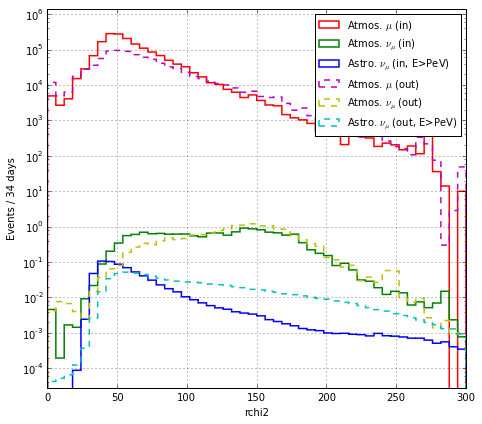

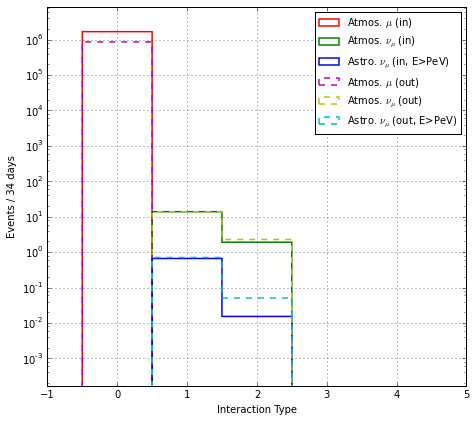

In [9]:
# Ok so now we are at the starting point for the EHE online alert. From
# here we normally proceed with the total combined event counts. What might
# be interesting is if we can change the cuts and get more events for outer
# and inner events, given larger energy events should deposit more charge
# based on how close/far it is away from the detector.

#Plot some basic variables
plot(info, 'cos(ImpLF_zen)',r'cos($\theta$)',50,-1,1,True,'baseline/coszen')
plot(info,'log10(hs_q_tot_pulses)','log10(NPE)',50,3,7,True,'baseline/lognpe')
plot(info,'hm_nhit_doms','Nhit Doms',50,0,1500,True,'baseline/ndoms')
plot(info,'ImpLF_rchi2','rchi2',50,0,300,True,'baseline/rchi2')
plot(info,'InteractionType','Interaction Type',5,-0.5,4.5,True,'baseline/inttype')
plt.show()


In [38]:
# Pull in the nue dataset as well to check how these cuts look
nue = loader.getNuE()
nue_in = qlayerCut(nue,True,0.8)
nue_out = qlayerCut(nue,False,0.8)

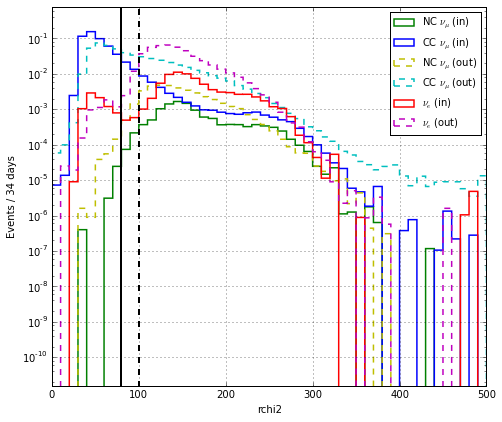

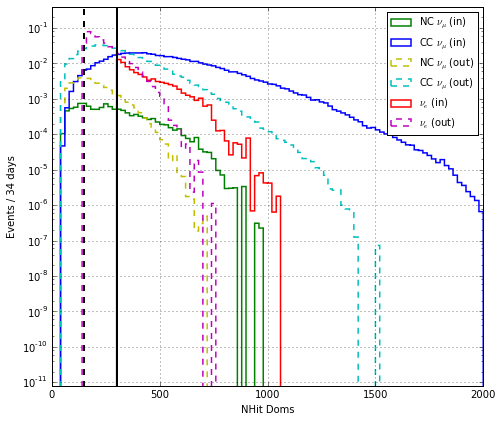

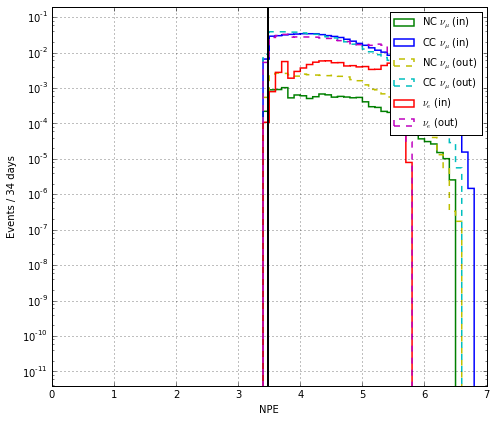

In [43]:
# I want to make this a track sample, so let's purify by cutting
# on improved line fit, similar to before. Do we need to cut as harshly?
# From looking at nu_e events we can get some idea that < 80 did a good
# job, but maybe we can be a little looser.  What do CC events look like?

numu_in_cc  = d_numupev_in[ d_numupev_in['InteractionType'] == 1 ]
numu_in_nc  = d_numupev_in[ d_numupev_in['InteractionType'] == 2 ]
numu_out_cc = d_numupev_out[ d_numupev_out['InteractionType'] == 1 ]
numu_out_nc = d_numupev_out[ d_numupev_out['InteractionType'] == 2 ]

def npecut(dt):
    return dt[ dt['log10(hs_q_tot_pulses)'] > np.log10(3000) ]
numu_in_cc = npecut(numu_in_cc)
numu_in_nc = npecut(numu_in_nc)
numu_out_cc = npecut(numu_out_cc)
numu_out_nc = npecut(numu_out_nc)

nue_in = npecut(nue_in)
nue_out = npecut(nue_out)

temp = {'data' : [numu_in_nc, numu_in_cc,numu_out_nc,numu_out_cc,nue_in,nue_out],
        'col' : ['g','b','y','c','r','m'],
        'lbl' : [r'NC $\nu_{\mu}$ (in)', 
                 r'CC $\nu_{\mu}$ (in)', 
                 r'NC $\nu_{\mu}$ (out)', 
                 r'CC $\nu_{\mu}$ (out)',
                 r'$\nu_{e}$ (in)',
                 r'$\nu_{e}$ (out)'],
        'ls'  : ['solid','solid','dashed','dashed','solid','dashed'],
        'w'   : ['wE2','wE2','wE2','wE2','wE2','wE2']
        }

plot(temp,'ImpLF_rchi2','rchi2',50,0,500,True,'cutopt/rchi2')
plt.plot([80,80],[1e-15,1],lw=2,c='black')
plt.plot([100,100],[1e-15,1],lw=2,c='black',ls='dashed')
plot(temp,'hm_nhit_doms','NHit Doms',100,0,2000,True,'cutopt/ndoms')
plt.plot([300,300],[1e-15,1],lw=2,c='black')
plt.plot([150,150],[1e-15,1],lw=2,c='black',ls='dashed')
plot(temp,'log10(hs_q_tot_pulses)','NPE',70,0,7,True,'cutopt/npe')
plt.plot([np.log10(3000),np.log10(3000)],[1e-15,1],lw=2,c='black')

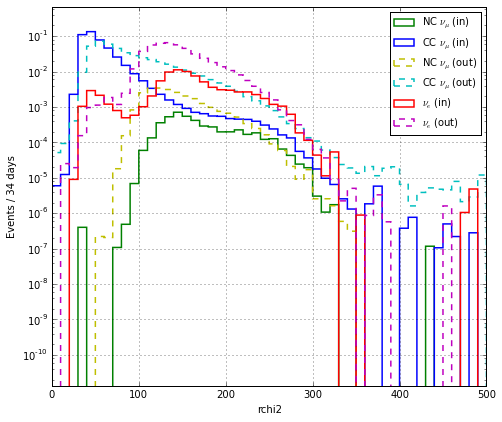

In [45]:
# Cut on Ndoms shown above

def ndomcut(dt,cval):
    return dt[ dt['hm_nhit_doms'] > cval]

numu_in_nc = ndomcut(numu_in_nc, 300)
numu_in_cc = ndomcut(numu_in_cc, 300)
nue_in = ndomcut(nue_in, 300)
numu_out_nc = ndomcut(numu_out_nc, 150)
numu_out_cc = ndomcut(numu_out_cc, 150)
nue_out = ndomcut(nue_out, 150)

temp = {'data' : [numu_in_nc, numu_in_cc,numu_out_nc,numu_out_cc,nue_in,nue_out],
        'col' : ['g','b','y','c','r','m'],
        'lbl' : [r'NC $\nu_{\mu}$ (in)', 
                 r'CC $\nu_{\mu}$ (in)', 
                 r'NC $\nu_{\mu}$ (out)', 
                 r'CC $\nu_{\mu}$ (out)',
                 r'$\nu_{e}$ (in)',
                 r'$\nu_{e}$ (out)'],
        'ls'  : ['solid','solid','dashed','dashed','solid','dashed'],
        'w'   : ['wE2','wE2','wE2','wE2','wE2','wE2']
        }

plot(temp,'ImpLF_rchi2','rchi2',50,0,500,True,'cutopt/rchi2_ndomcut')

In [34]:
# How much do I lose at each cut?  
def cutd(dt,var,cval,gt):
    tots = sum(dt['wE2']) * 365/34.7
    if gt: 
        left = sum(dt[ dt[var] > cval ]['wE2']) * 365/34.7
    else:
        left = sum(dt[ dt[var] < cval ]['wE2']) * 365/34.7
    print left, left/tots

print "Nch: "
cutd(numu_in_cc,'hm_nhit_doms',300,True)
cutd(numu_out_cc,'hm_nhit_doms',150, True)
cutd(nue,'hm_nhit_doms',300,True)

print "rchi2: "
cutd(numu_in_cc,'ImpLF_rchi2',80,False)
cutd(numu_out_cc,'ImpLF_rchi2',100,False)
cutd(numu_in_cc[numu_in_cc['hm_nhit_doms']>300],'ImpLF_rchi2',80,False)
cutd(numu_out_cc[numu_out_cc['hm_nhit_doms']>150],'ImpLF_rchi2',100,False)



Nch: 
4.61286135253 0.813235647465
4.6912372788 0.846930236875
rchi2: 
4.93352473174 0.869767780317
3.4329092832 0.619758605161
4.1551313901 0.900770925582
3.15523834934 0.672581274795


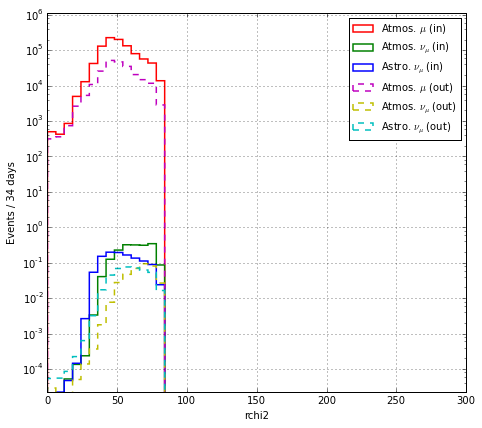

In [38]:
# It looks like we could loosen the chi2 cut a bit  
# So let's cut:
#    * Inner events: < 100
#    * Outer events: < 80

def cutrchi2(data, cutval):
    return data[ data['ImpLF_rchi2'] < cutval]

# Loop and apply cut
for i in range(len(info['data'])):
    cval = 80
    if 'out' in info['lbl'][i]:
        cval = 80
    info['data'][i] = cutrchi2(info['data'][i],cval)

# Plot to make sure
plot(info,'ImpLF_rchi2','rchi2',50,0,300,True)


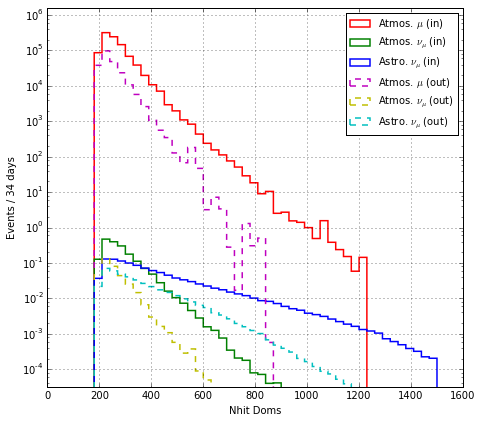

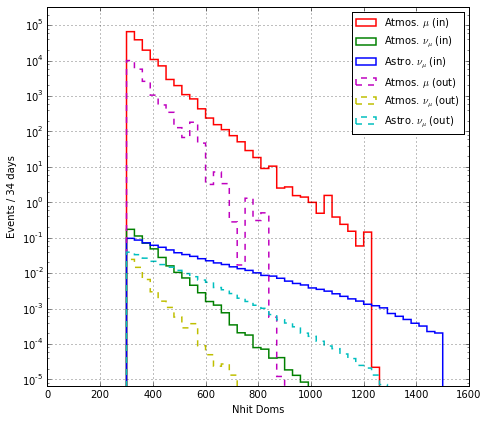

In [39]:
# The next cut will be on the number of Hit Doms
plot(info,'hm_nhit_doms','Nhit Doms',50,0,1500,True)

# So after looking it seems cutting at 100 is easy enough
def cutndom(data, cutval):
    return data[ data['hm_nhit_doms'] > cutval]

# Loop and apply cut
for i in range(len(info['data'])):
    cval = 300
    if 'out' in info['lbl'][i]:
        cval = 300
    info['data'][i] = cutndom(info['data'][i],cval)

# Plot and show the result
plot(info,'hm_nhit_doms','Nhit Doms',50,0,1500,True)

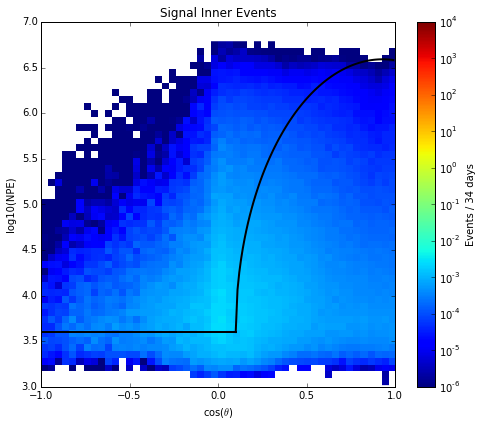

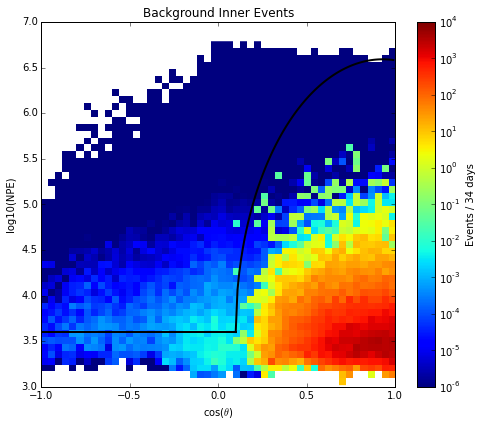

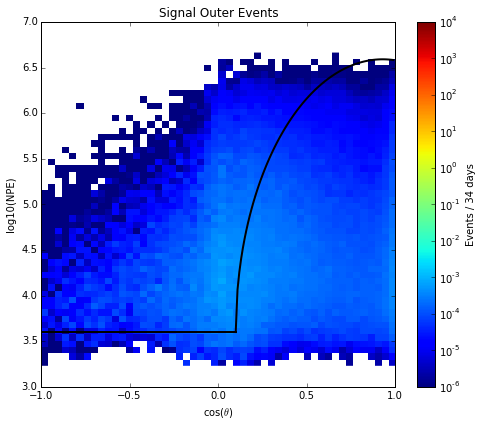

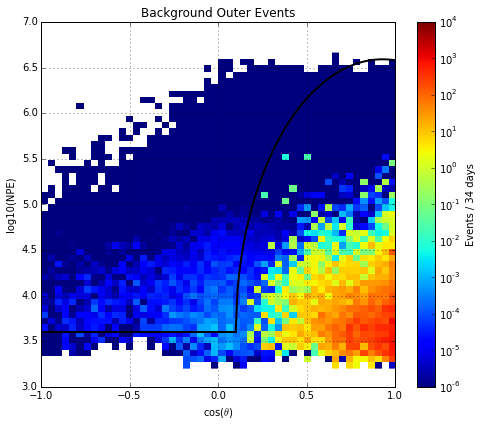

In [45]:
# Ok we are essentially ready for the 2D optimization, Let's
# Take a look at the distributions

# Combine corsika and atmos nu
d_bkg_in  = pd.concat([info['data'][0],info['data'][1]])
d_bkg_out = pd.concat([info['data'][3],info['data'][4]])

# Pick out astro numu
d_sig_in  = info['data'][2]
d_sig_out = info['data'][5]

# Plot constants
nbins = 50
xmin  = -1
xmax  = 1
ymin  = 3
ymax  = 7
zmin  = 1e-6
zmax  = 1e4

# Create a plot tool for 2D plots
pt = PlotTool()
 
# Method to draw previous cuts
def drawCuts(axis):
    axis.plot([-1,0.1], [3.6,3.6], c='black', lw=2)
    def f(x):
        return 3.6 + 2.99 * np.sqrt(np.fabs(1-np.power((x-0.93)/0.83,2)))
    step = 0.01
    x = np.arange(0.1,1,step)
    axis.plot(x,f(x),c='black',lw=2)
              
    
   
# Plot 2D for inner
fig, ax = plt.subplots(ncols=1,figsize=(7,6))

xval = 'cos(ImpLF_zen)'
yval = 'log10(NPE)'
ax.set_title("Signal Inner Events")
pt.ploth2(d_sig_in[xval].as_matrix(),
        d_sig_in[yval].as_matrix(),
        d_sig_in['wE2'].as_matrix(), 
        r'cos($\theta$)',
        'log10(NPE)',
        C.lt_label,
        nbins,xmin,xmax,ymin,ymax,zmin,zmax,
        False)
cb = plt.colorbar()
cb.set_label(C.lt_label)
drawCuts(ax)

fig, ax = plt.subplots(ncols=1,figsize=(7,6))
ax.set_title("Background Inner Events")
pt.ploth2(d_bkg_in[xval].as_matrix(),
         d_bkg_in[yval].as_matrix(),
         d_bkg_in['w'].as_matrix(), 
         r'cos($\theta$)',
         'log10(NPE)',
         C.lt_label,
         nbins,xmin,xmax,ymin,ymax,zmin,zmax,
        False)
cb = plt.colorbar()
cb.set_label(C.lt_label)
drawCuts(ax)

# Plot 2D for inner
fig, ax = plt.subplots(ncols=1,figsize=(7,6))

ax.set_title("Signal Outer Events")
pt.ploth2(d_sig_out[xval].as_matrix(),
        d_sig_out[yval].as_matrix(),
        d_sig_out['wE2'].as_matrix(), 
        r'cos($\theta$)',
        'log10(NPE)',
        C.lt_label,
        nbins,xmin,xmax,ymin,ymax,zmin,zmax,
        False)
cb = plt.colorbar()
cb.set_label(C.lt_label)
drawCuts(ax)

fig, ax = plt.subplots(ncols=1,figsize=(7,6))
ax.set_title("Background Outer Events")
pt.ploth2(d_bkg_out[xval].as_matrix(),
         d_bkg_out[yval].as_matrix(),
         d_bkg_out['w'].as_matrix(), 
         r'cos($\theta$)',
         'log10(NPE)',
         C.lt_label,
         nbins,#0,0.5,5.0,6.0,zmin,zmax,
          xmin,xmax,ymin,ymax,zmin,zmax,
         False)
cb = plt.colorbar()
cb.set_label(C.lt_label)
drawCuts(ax)
plt.grid()



In [63]:
# Setup the method for doing the signal region scanning

xval = 'cos(ImpLF_zen)'
yval = 'log10(hs_q_tot_pulses)'
def getdata(dt, threshold, a, b):
    y = dt[yval]
    x = dt[xval]
    down = (x >= 0.15) & (y >= threshold + b * np.sqrt(1-np.power((x-a-0.1)/a,2)))
    up   = (x<0.15) & (y >= threshold)
    return dt[ down | up]
def getSum(dt, threshold, a, b, w):
    temp = getdata(dt,threshold,a,b)
    return sum(temp[w])

In [64]:
# Repeat the optimization for outer and inner events following
# the original idea which is to look at the ratio of signal to 
# background for a set of cuts

# Create the x-y grid
a = np.arange(0.5,1.51,0.1)
b = np.arange(0.5,4,0.1)

# Now get the results for a specific set
sf = 365/34.7
def prepare(dt, th, a, b, w):
    x = []
    y = []
    z = []
    for a_ in a:
        for b_ in b:
            x.append(a_)
            y.append(b_)
            z.append(getSum(dt, th, a_, b_, w) * sf)
    return x, y, z

sigscan = {3.6 : [],
           3.7 : [],
           3.8 : [],
           4.0 : []}
for cval in sigscan:
    s_in  = prepare(d_sig_in, cval, a, b, 'wE2')
    s_out = prepare(d_sig_out, cval, a, b, 'wE2')
    b_in  = prepare(d_bkg_in, cval, a, b, 'w')
    b_out = prepare(d_bkg_out, cval, a, b, 'w')    

    sigscan[cval] = [s_in, b_in, s_out, b_out]



In [56]:
# Some small checks
nsig = getSum(pd.concat([d_sig_in,d_sig_out]), 3.6, 0.83, 2.99, 'wE2') * 365/34.7
nbkg = getSum(pd.concat([d_bkg_in,d_bkg_out]), 3.6, 0.83, 2.99, 'w') * 365/34.7
print nsig, nbkg

4.06317659376 1.70311186168


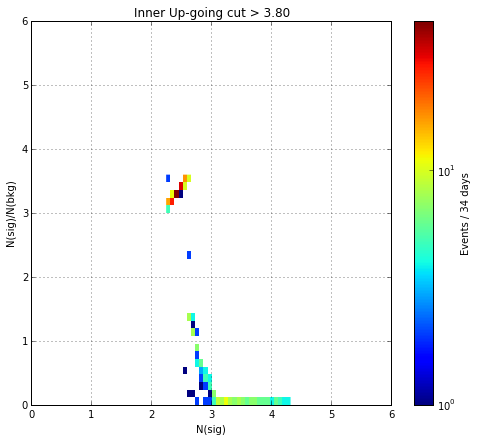

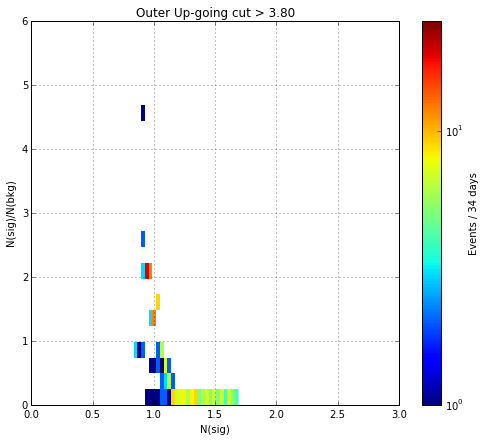

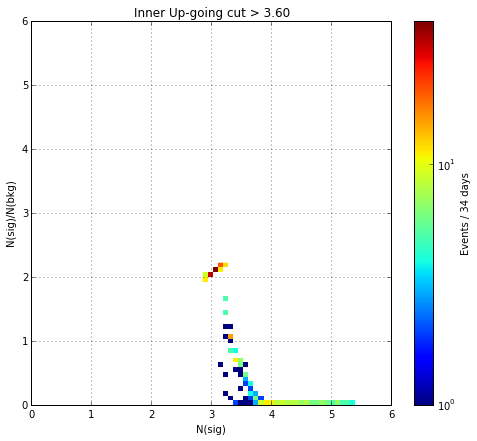

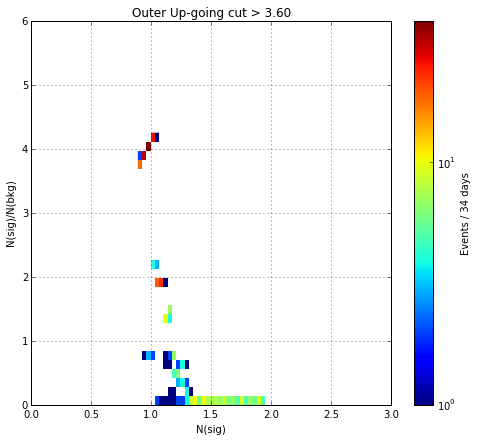

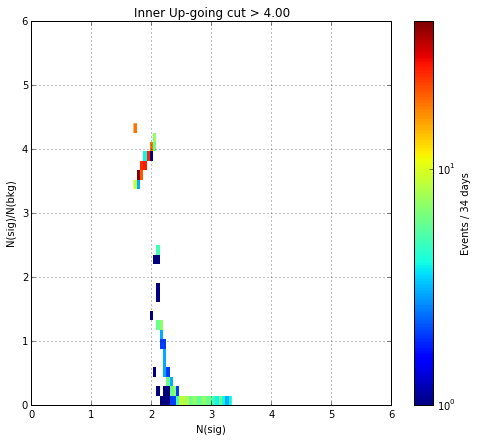

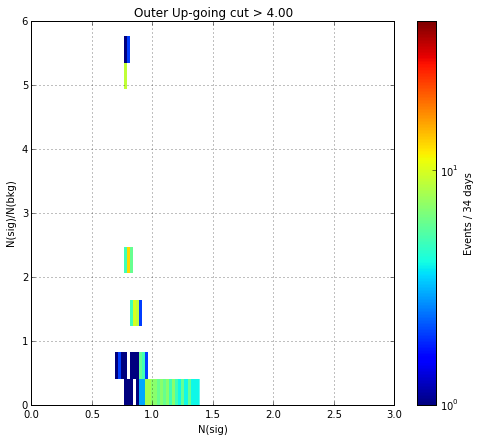

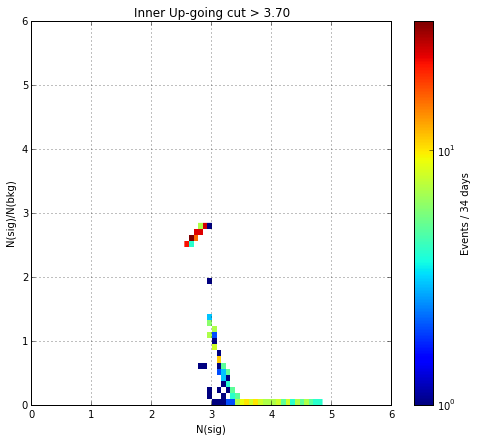

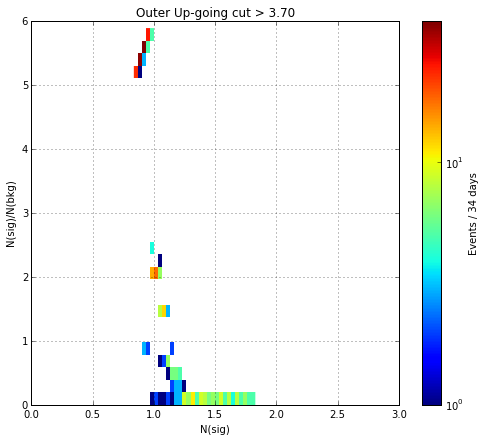

In [57]:
# Now plot the data to look for the most optimum cut requirement
# We want to look at N(sig)/N(bkg) vs. N(sig)

def getRatio(sig, bkg):
    ratio = []
    for i in range(len(sig)):
        if bkg[i] != 0:
            ratio.append(sig[i]/bkg[i])
        else:
            ratio.append(10000)
    return ratio

# Loop over the cut values and make the plots
for cval in sigscan:

    # Setup the data
    s_in = sigscan[cval][0]
    b_in = sigscan[cval][1]
    s_out = sigscan[cval][2]
    b_out = sigscan[cval][3]
    
    fig = plt.figure(figsize=(7,6))
    r_in = getRatio(s_in[2],b_in[2])      
    pt.ploth2(s_in[2], r_in, np.ones(len(r_in)), 'N(sig)','N(sig)/N(bkg)',
              '# Combinations',
              30,0,6,0,6,-1,-1,
              False)
    cb = plt.colorbar()
    cb.set_label(C.lt_label)
    plt.grid()
    plt.title('Inner Up-going cut > %.2f'%(cval))

    fig = plt.figure(figsize=(7,6))
    r_out = getRatio(s_out[2],b_out[2])      
    pt.ploth2(s_out[2], r_out, np.ones(len(r_out)), 'N(sig)','N(sig)/N(bkg)',
              '# Combinations',
              30,0,3,0,6,-1,-1,
              False)
    cb = plt.colorbar()
    cb.set_label(C.lt_label)
    plt.grid()
    plt.title('Outer Up-going cut > %.2f'%(cval))




In [62]:
# Ok so let's try to find the maximum ratio N(sig)/N(bkg) 
# for each set of cut parameters.  This is kind of sloppy
# for now because I didn't use any numpy arrays... just 
# wrap it up for the meeting though and fix later.

def pinfo(sig, bkg, rat):
    
    rmax = -999
    nsig = -999
    nbkg = -999
    a    = -999
    b    = -999
    
    for i in range(len(rat)):
        if rat[i] > rmax:
            rmax = rat[i]
            nsig = sig[2][i]
            nbkg = bkg[2][i]
            a    = bkg[0][i]
            b    = bkg[1][i]
            
    print "\t", rmax, nsig, nbkg, a, b

for cval in sigscan:

    # Setup the data
    s_in = sigscan[cval][0]
    b_in = sigscan[cval][1]
    s_out = sigscan[cval][2]
    b_out = sigscan[cval][3]
    
    r_in = getRatio(s_in[2], b_in[2])
    r_out = getRatio(s_out[2], b_out[2])
    
    print "----------------"
    print cval
    print "Inner"
    pinfo(s_in, b_in, r_in)
    print "Outer"
    pinfo(s_out,b_out,r_out)
    

----------------
3.8
Inner
	3.58999236647 2.25181523044 0.627247916031 0.5 3.8
Outer
	7.38691178095 0.91615984162 0.12402474387 1.2 2.7
----------------
3.6
Inner
	2.21714949331 3.2453828884 1.46376367412 0.6 2.2
Outer
	4.24373608031 1.03002452947 0.242716443713 0.6 2.3
----------------
4.0
Inner
	4.39070810686 1.74261111165 0.39688612161 0.5 3.1
Outer
	12.3080359251 0.769989689435 0.0625599156615 1.1 2.3
----------------
3.7
Inner
	2.83830147326 2.93818061985 1.03518975963 0.8 2.3
Outer
	5.87400576433 0.975326946342 0.166041196668 0.7 2.3


In [65]:
# Ok so let's try to find the maximum ratio N(sig)/N(bkg) 
# for each set of cut parameters.  This is kind of sloppy
# for now because I didn't use any numpy arrays... just 
# wrap it up for the meeting though and fix later.

def pinfo(sig, bkg, rat):
    
    rmax = -999
    nsig = -999
    nbkg = -999
    a    = -999
    b    = -999
    
    for i in range(len(rat)):
        if rat[i] > rmax:
            rmax = rat[i]
            nsig = sig[2][i]
            nbkg = bkg[2][i]
            a    = bkg[0][i]
            b    = bkg[1][i]
            
    print "\t", rmax, nsig, nbkg, a, b

for cval in sigscan:

    # Setup the data
    s_in = sigscan[cval][0]
    b_in = sigscan[cval][1]
    s_out = sigscan[cval][2]
    b_out = sigscan[cval][3]
    
    r_in = getRatio(s_in[2], b_in[2])
    r_out = getRatio(s_out[2], b_out[2])
    
    print "----------------"
    print cval
    print "Inner"
    pinfo(s_in, b_in, r_in)
    print "Outer"
    pinfo(s_out,b_out,r_out)
    

----------------
3.8
Inner
	3.54581885541 2.75511374895 0.777003524799 0.9 2.3
Outer
	7.00690337421 0.957015041391 0.136581738077 1.2 2.7
----------------
3.6
Inner
	2.16767669325 3.41268157161 1.5743498937 0.6 2.2
Outer
	4.17190453364 1.07471275163 0.257607225421 0.6 2.3
----------------
4.0
Inner
	4.2077529392 2.18286210214 0.51877145205 0.6 1.7
Outer
	11.7740074433 0.80779994562 0.0686087510567 1.1 2.3
----------------
3.7
Inner
	2.79187175952 3.08758882504 1.1059207195 0.8 2.3
Outer
	5.66431854226 1.01888299821 0.179877418723 0.7 2.3
